This code is modified from the code at the below link.

https://colab.research.google.com/github/khalidmeister/Customer-Segmentation-using-Python/blob/master/Customer%20Segmentation%20in%20Python.ipynb

# Customer Segmentation
## Using $k$-means clustering algorithm

Our goal is to segment customers based on their buying behaviour on the market.  We will use $k$-means algorithm.

#### Gathering Data

In [1]:
# ! pip install xlrd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
FILE = 'https://www.dropbox.com/s/suu7vnec5oxw91j/data.csv?dl=1'
df = pd.read_csv(FILE, encoding= 'unicode_escape')
df = df[df['CustomerID'].notna()] # Remove the customers with missing Customer ID
df_fix = df.sample(10000, random_state = 42) # Sample 10,000 rows from the dataframe
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,1/7/2011 12:14,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,9/15/2011 13:51,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,8/3/2011 10:10,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,9/4/2011 13:56,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,9/8/2011 12:20,0.55,15144.0,United Kingdom


### Data Preprocessing
#### Create RFM Table

In [2]:
# Convert to show date only
from datetime import datetime
df_fix['InvoiceDate'] = pd.to_datetime(df_fix['InvoiceDate'], format='%m/%d/%Y %H:%M')


In [3]:
# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) 

# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,'InvoiceNo': 'count','TotalSum': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency','TotalSum': 'MonetaryValue'}, inplace=True)


In [4]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,38,5,133.20
12348.0,248,2,120.88
12349.0,18,2,312.75
12352.0,71,5,80.85
12354.0,231,2,33.30


#### Manage Skewness

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

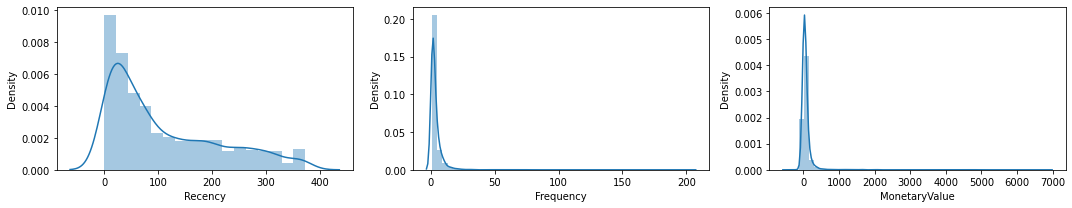

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In [6]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

In [7]:
pd.Series(np.cbrt(customers['MonetaryValue'])).values

array([ 5.10702607,  4.94445183,  6.78785317, ..., -1.66910753,
        4.27320639,  4.0872497 ])

In [8]:
# Set the Numbers
import scipy.special as sc
customers_fix = customers
customers_fix.tail()

,Recency,Frequency,MonetaryValue
CustomerID,,,
18265.0,71,2,39.60
18272.0,1,11,206.17
18274.0,17,2,-4.65
18283.0,3,21,78.03
18287.0,42,4,68.28


#### Centering and Scaling Variables

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


In [10]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,-0.696338,0.178753,0.233713
1,1.354994,-0.239374,0.185381
2,-0.891703,-0.239374,0.938099
3,-0.373986,0.178753,0.028341
4,1.188934,-0.239374,-0.158200


### Modelling
#### Choose k-number

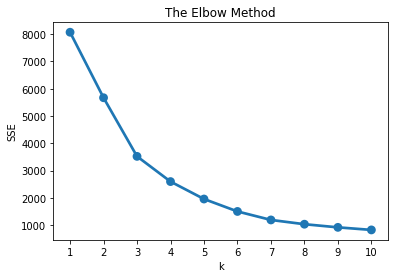

In [11]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [12]:
model = KMeans(n_clusters=3, random_state=42) # We select a model with 3 clusters
model.fit(customers_normalized)
model.labels_.shape

(2690,)

In [13]:
customers.shape

(2690, 3)

### Cluster Analysis

In [14]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,38,5,133.20,0
12348.0,248,2,120.88,1
12349.0,18,2,312.75,0
12352.0,71,5,80.85,0
12354.0,231,2,33.30,1


In [15]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          49.8       4.1          72.8  1855
1         245.3       1.8          32.9   821
2           9.4      65.1        2574.7    14

### Plot

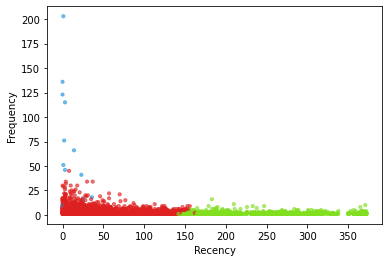

In [16]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
customers['cen_x'] = customers.Cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
customers['cen_y'] = customers.Cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
customers['c'] = customers.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
import matplotlib.pyplot as plt
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.scatter(customers.Recency, customers.Frequency, c=customers.c, alpha = 0.6, s=10)


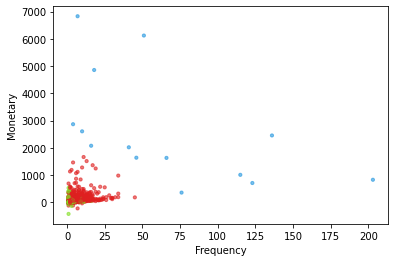

In [17]:
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.scatter(customers.Frequency, customers.MonetaryValue, c=customers.c, alpha = 0.6, s=10)


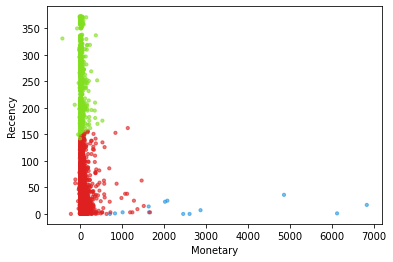

In [18]:
plt.xlabel('Monetary')
plt.ylabel('Recency')
plt.scatter(customers.MonetaryValue, customers.Recency, c=customers.c, alpha = 0.6, s=10)


### References
Daqing C., Sai L.S, and Kun G., Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining (2012), Journal of Database Marketing and Customer Strategy Management.<br>
K. Jarrod Millman and Michael Aivazis. Python for Scientists and Engineers(2011). Computing in Science & Engineering.<br>
https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45<br>
https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/